<a href="https://colab.research.google.com/github/vaetheneeb/ktmb-ridership-peak-prediction/blob/main/WIA1006_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing and Engineering

In [ ]:
# load dataset
url = 'https://storage.data.gov.my/transportation/ktmb/komuter_2025.csv'
import pandas as pd
df = pd.read_csv(url)

# display first few rows
print(df.head())
print()

# get dataset info
print(df.info())
print()

# check missing values
print("Missing values:")
print(df.isnull().sum())
print()

# check duplicate rows
print(f"Duplicate rows: {df.duplicated().sum()}")
print()

         date   time          origin       destination  ridership
0  2025-01-01  00:00  Abdullah Hukum             Klang          1
1  2025-01-01  00:00  Abdullah Hukum       Telok Pulai          1
2  2025-01-01  00:00           Bangi        Batu Caves          1
3  2025-01-01  00:00     Bank Negara      Sungai Gadut          1
4  2025-01-01  00:00       Batu Tiga  Kampung Raja Uda          1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 946455 entries, 0 to 946454
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   date         946455 non-null  object
 1   time         946455 non-null  object
 2   origin       946455 non-null  object
 3   destination  946455 non-null  object
 4   ridership    946455 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 36.1+ MB
None

Missing values:
date           0
time           0
origin         0
destination    0
ridership      0
dtype: int64

Duplicate rows: 0



In [ ]:
#no missing rows
#no duplicate rows

In [ ]:
# convert date and time columns and extract features
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], errors='coerce')

# check for conversion issues (should be 0)
print(df['datetime'].isnull().sum())
print()

# extract hour and day of the week
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek  # Monday=0, Sunday=6

# add holiday flag
import holidays

malaysia_holidays = holidays.MY(years=[2025])
df['is_holiday'] = df['datetime'].dt.date.apply(lambda x: x in malaysia_holidays).astype(int)

0



In [ ]:
# normalize numerical features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['ridership_scaled'] = scaler.fit_transform(df[['ridership']])

# encode categorical features
from sklearn.preprocessing import LabelEncoder

df['station_pair'] = df['origin'] + '_' + df['destination']
le = LabelEncoder()
df['station_pair_encoded'] = le.fit_transform(df['station_pair'])

In [ ]:
#more feature engineering
# Hour bin (0=earlymorning, 1=morning, 2=afternoon, 3=evening, 4=night)
df['hour_bin'] = pd.cut(df['hour'], bins=[0,5,10,15,20,24], labels=[0,1,2,3,4], right=False).cat.add_categories([-1]).fillna(-1).astype(int)

# Is weekend
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Interaction features
df['hour_is_weekend'] = df['hour'] * df['is_weekend']
df['hour_is_holiday'] = df['hour'] * df['is_holiday']

#encode origin and destination
le_origin = LabelEncoder()
le_destination = LabelEncoder()
df['origin_encoded'] = le_origin.fit_transform(df['origin'])
df['destination_encoded'] = le_destination.fit_transform(df['destination'])


In [ ]:
# create peak_label based on ridership (top 25% = peak)
threshold = df['ridership'].quantile(0.75)
df['peak_label'] = (df['ridership'] >= threshold).astype(int)

# clean and finalize dataset
df = df.drop(['date', 'time', 'datetime', 'origin', 'destination', 'station_pair'], axis=1, errors='ignore')

In [ ]:
# define features and label
X = df.drop('peak_label', axis=1)
y = df['peak_label']

In [ ]:
# export cleaned dataset
df.to_csv('final_cleaned_ktmb_data.csv', index=False)

# Machine Learning Models

In [ ]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from google.colab import files
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC, LinearSVC
import seaborn as sns

In [ ]:
#load cleaned dataset (25% peak)
uploaded = files.upload()
df = pd.read_csv('final_cleaned_ktmb_data.csv')

Saving final_cleaned_ktmb_data.csv to final_cleaned_ktmb_data (1).csv


In [ ]:
#empty list to hold result
results = []

In [ ]:
#↓ Model 1 : Decision Tree

In [ ]:
#Decision Tree
#prepare features and label
# Define features (X) and target label (y)
features_tree = ['hour', 'day_of_week', 'is_holiday', 'hour_bin', 'is_weekend', 'hour_is_weekend', 'hour_is_holiday', 'station_pair_encoded', 'origin_encoded', 'destination_encoded']
X_tree = df[features_tree]
y = df['peak_label']

#split data to train and test
X_tree_train, X_tree_test, y_train, y_test = train_test_split(X_tree, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Define parameter grid to tune
param_grid = {'max_depth': [6, 8, 10, 12, 15], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 5], 'criterion': ['gini', 'entropy']}

# Create GridSearchCV object
grid = GridSearchCV(DecisionTreeClassifier(class_weight='balanced', random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearch to your data
grid.fit(X_tree_train, y_train)

# Output best parameters and score
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Accuracy:", grid.best_score_)

# Use best model on test set
best_model = grid.best_estimator_

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best Cross-Validation Accuracy: 0.8065799987345479


In [ ]:
#evaluate the mode
#make predictions
y_pred = best_model.predict(X_tree_test)

# Evaluation metrics
print("===Decision Tree===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

#compare training vs test accuracy for decision tree
print("\nTraining Accuracy:", best_model.score(X_tree_train, y_train))
print("Testing Accuracy :", best_model.score(X_tree_test, y_test))

===Decision Tree===
Confusion Matrix:
 [[107483  23871]
 [ 11153  43299]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.82      0.86    131354
           1       0.64      0.80      0.71     54452

    accuracy                           0.81    185806
   macro avg       0.78      0.81      0.79    185806
weighted avg       0.83      0.81      0.82    185806


Accuracy: 0.8115023196236936
F1 Score: 0.7120257848086695

Training Accuracy: 0.8186625261362016
Testing Accuracy : 0.8115023196236936


In [ ]:
# Perform cross-validation on the full training set using the best model
cv_scores = cross_val_score(best_model, X_tree_train, y_train, cv=5, scoring='accuracy')

# Output the CV scores and mean
print("Cross-validation Accuracy Scores:", cv_scores)
print("Mean Cross-validation Accuracy:", round(cv_scores.mean(), 4))

Cross-validation Accuracy Scores: [0.80867839 0.80466211 0.80609375 0.80601302 0.80745271]
Mean Cross-validation Accuracy: 0.8066


In [ ]:
#collect result
results.append({
    'Model': 'Decision Tree',
    'Accuracy': accuracy_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
})

station_pair_encoded    0.331195
destination_encoded     0.286508
hour                    0.189158
origin_encoded          0.094198
day_of_week             0.041587
hour_bin                0.021440
hour_is_weekend         0.019380
hour_is_holiday         0.006501
is_weekend              0.005955
is_holiday              0.004078
dtype: float64


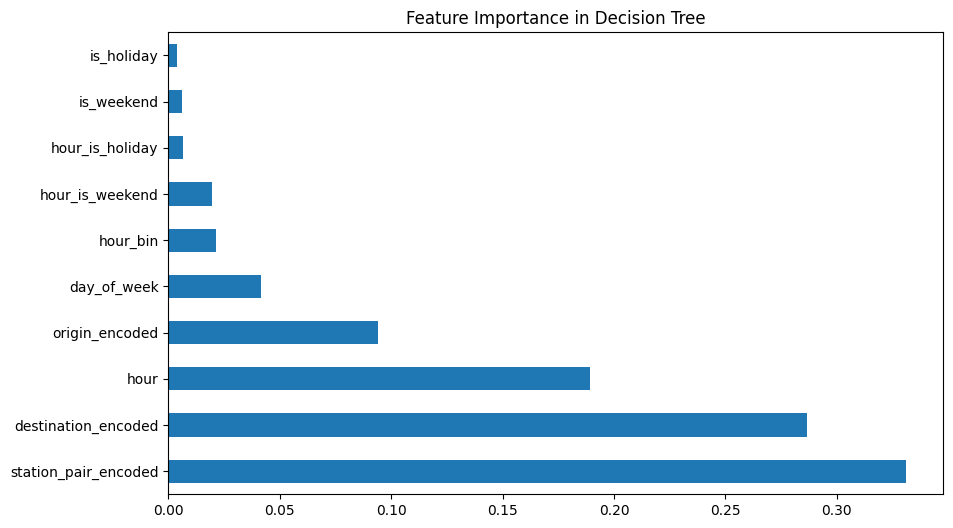

In [ ]:
best_model.feature_importances_

importances = best_model.feature_importances_
feat_importance = pd.Series(importances, index=X_tree.columns).sort_values(ascending=False)

print(feat_importance)

feat_importance.plot(kind='barh', figsize=(10,6))
plt.title("Feature Importance in Decision Tree")
plt.show()

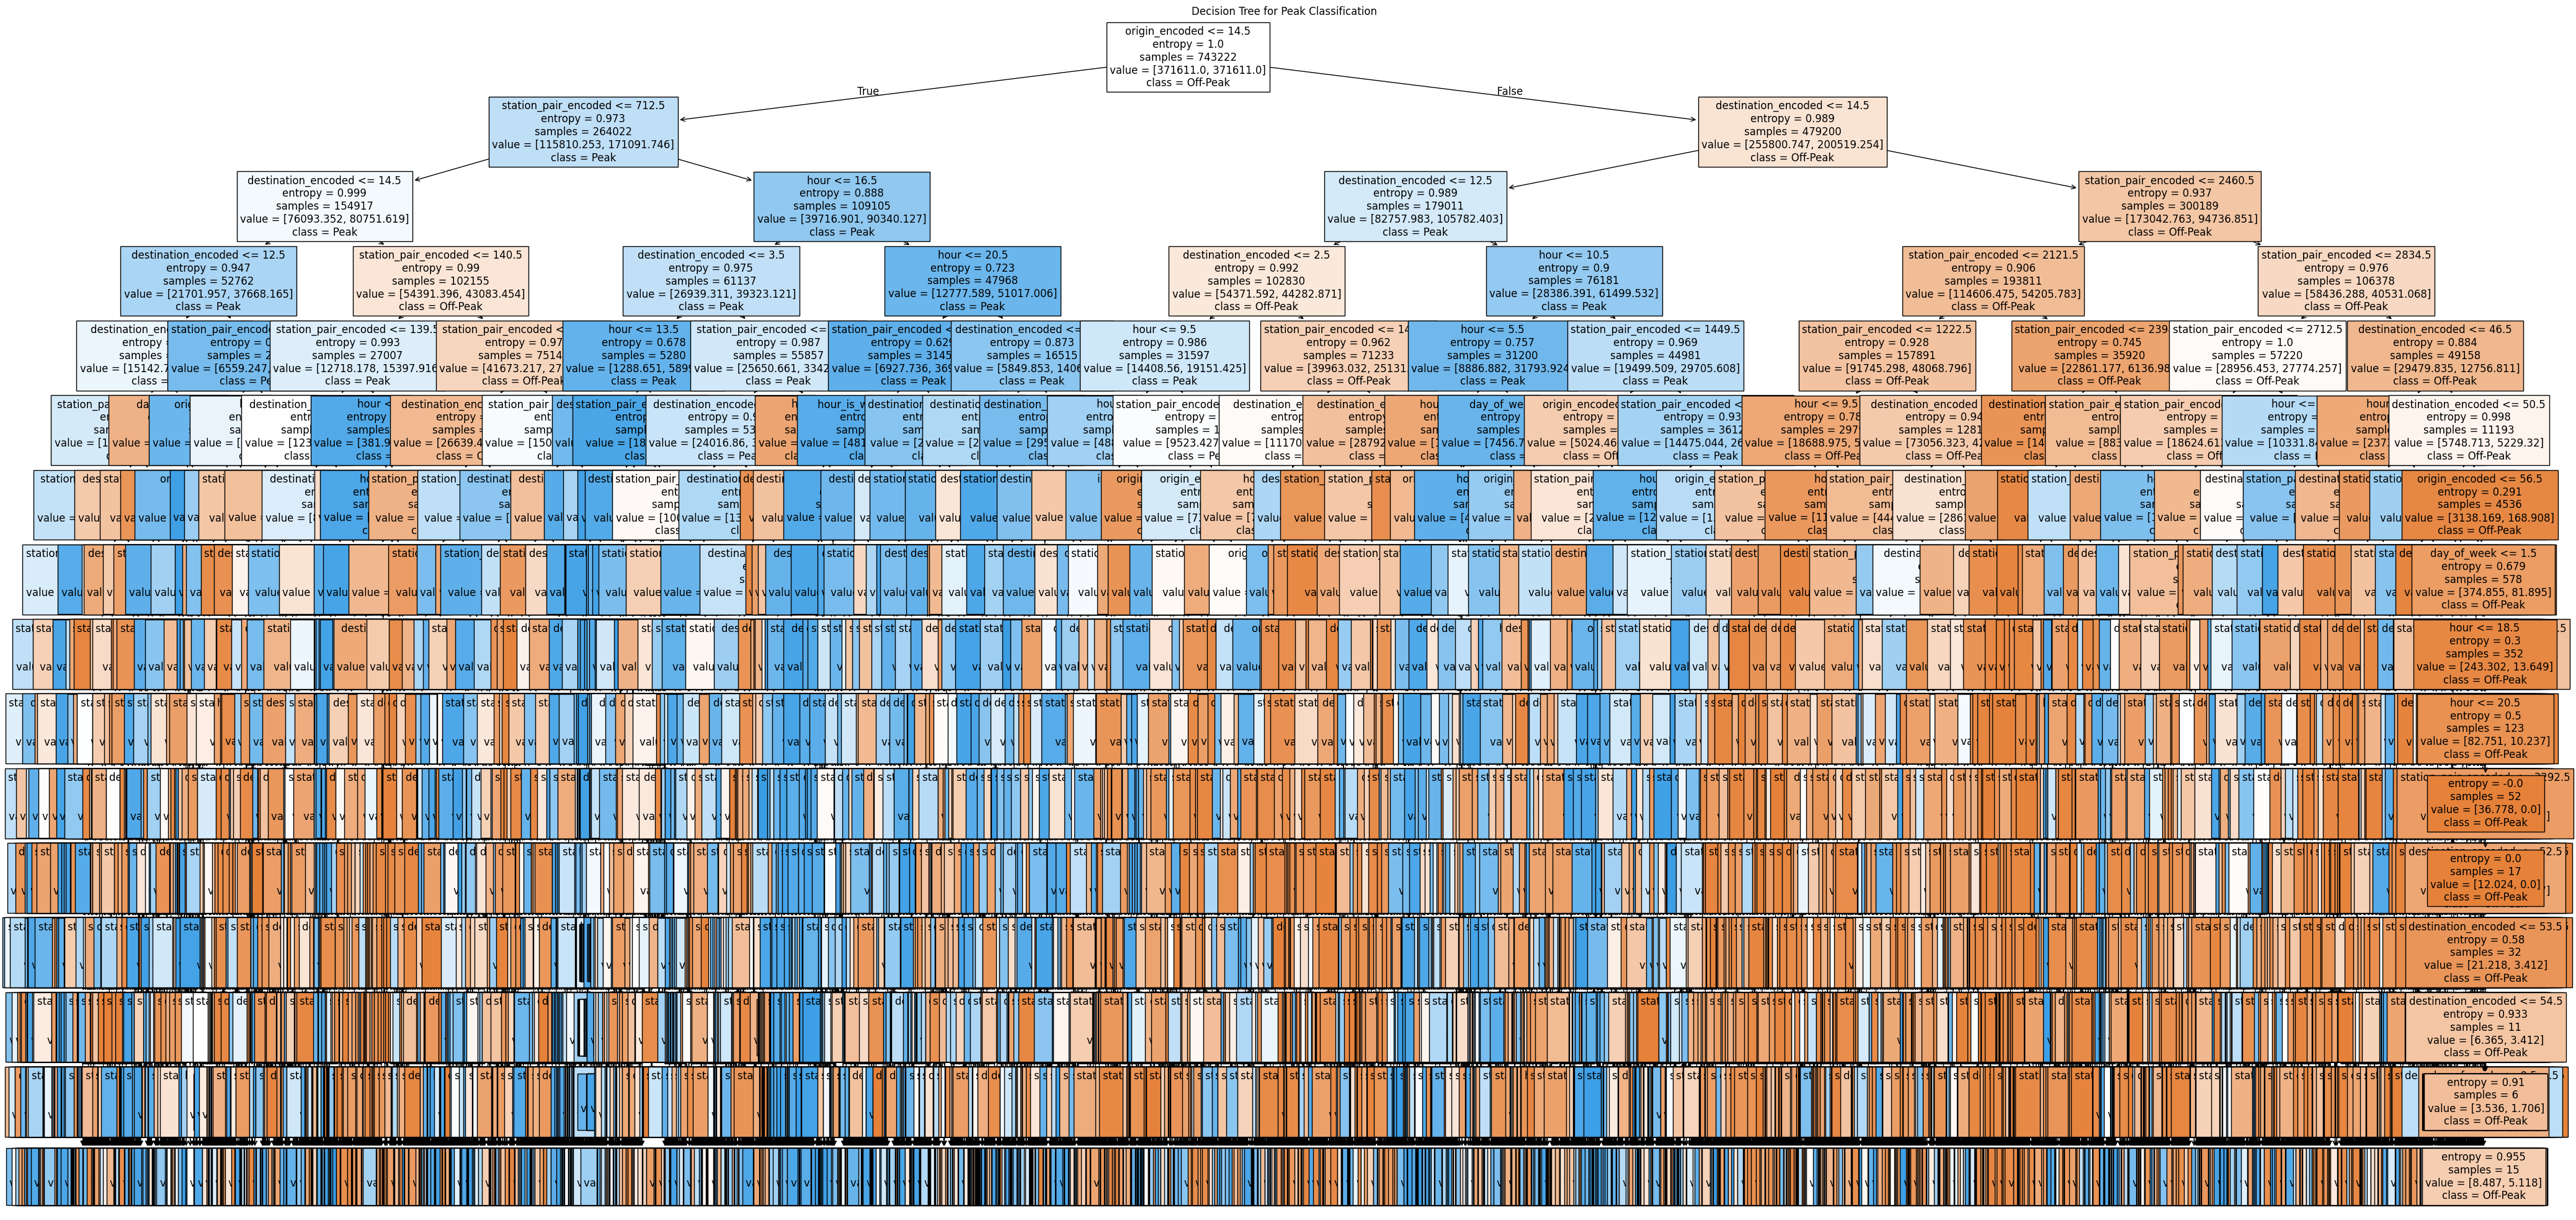

In [ ]:
#Visualize the Decision Tree
plt.figure(figsize=(50,25))
tree.plot_tree(best_model, feature_names=X_tree.columns, class_names=['Off-Peak', 'Peak'], filled=True, fontsize=12)
plt.title("Decision Tree for Peak Classification")
plt.show()

In [ ]:
#↓ Model 2 : Logistic Regression

In [ ]:
#Select Features and Target
mean_target = df.groupby('station_pair_encoded')['peak_label'].mean()
df['station_pair_encoded_target'] = df['station_pair_encoded'].map(mean_target)

# One-hot encode 'day_of_week' and 'hour_bin'
df = pd.get_dummies(df, columns=['day_of_week', 'hour_bin'], drop_first=True)

# Select final features
features_final = ['hour', 'is_holiday', 'is_weekend', 'hour_is_weekend', 'hour_is_holiday', 'station_pair_encoded_target'] + \
                 [col for col in df.columns if col.startswith('day_of_week_') or col.startswith('hour_bin_')]

X_logic = df[features_final]
y = df['peak_label']

In [ ]:
#split the Data
X_logic_train, X_logic_test, y_train, y_test = train_test_split(X_logic, y, test_size=0.2, random_state=42)

#scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_logic_train)
X_test_scaled = scaler.transform(X_logic_test)

In [ ]:
#train the model
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [ ]:
#test the model
y_pred = logreg.predict(X_test_scaled)

In [ ]:
#Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [ ]:
#cross-validation
cv_scores = cross_val_score(logreg, scaler.fit_transform(X_logic), y, cv=5)
print("\nCross-Validation Accuracy: {:.2f} ± {:.2f}".format(cv_scores.mean(), cv_scores.std()))


Cross-Validation Accuracy: 0.76 ± 0.01


In [ ]:
#Results
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print("Accuracy:", accuracy)


Confusion Matrix:
 [[101929  29457]
 [ 14327  40093]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.78      0.82    131386
           1       0.58      0.74      0.65     54420

    accuracy                           0.76    185806
   macro avg       0.73      0.76      0.74    185806
weighted avg       0.79      0.76      0.77    185806

Accuracy: 0.7643563716995145


In [ ]:
#collect result
results.append({
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
})

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


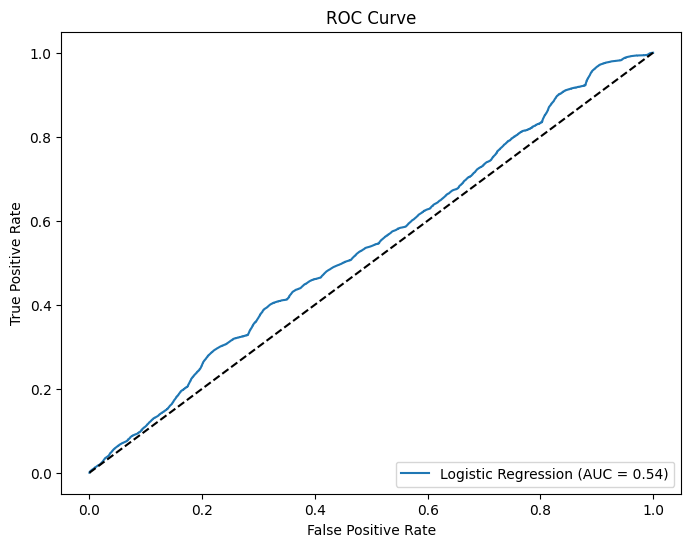

In [ ]:
#predict probabilities
y_prob = logreg.predict_proba(X_logic_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_score(y_test, y_prob)))
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

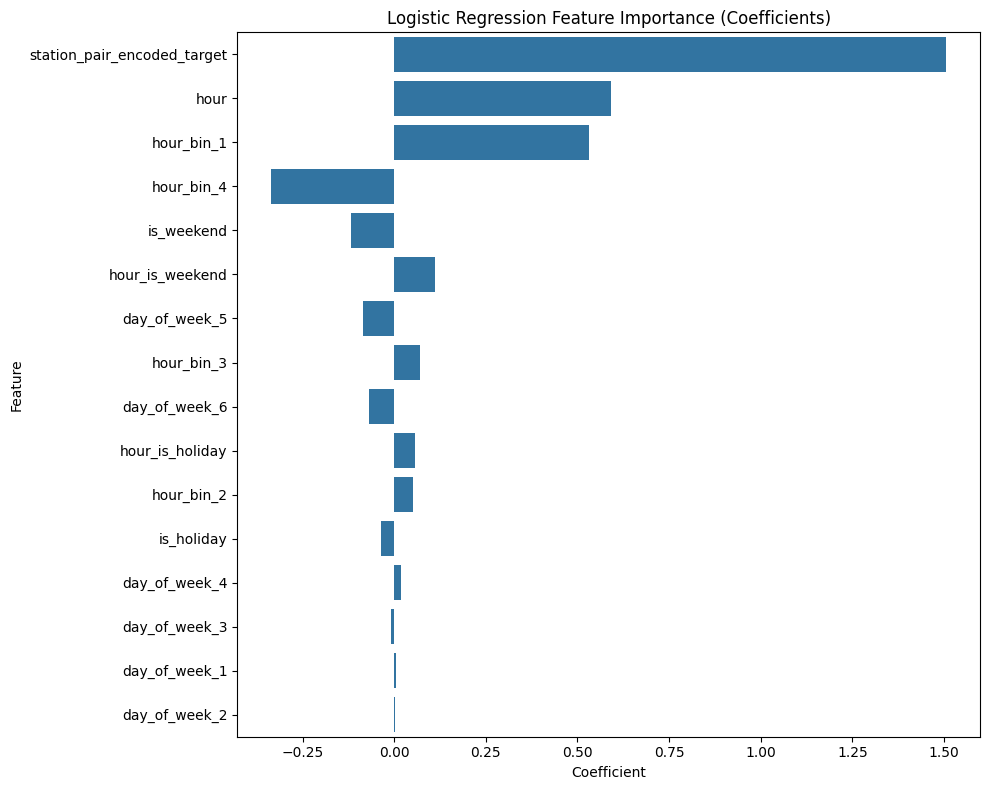

In [ ]:
# Get feature names and coefficients
feature_names = X_logic.columns
coefficients = logreg.coef_[0]

# Create DataFrame for easy plotting
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort by absolute value of coefficient
coef_df['abs_coeff'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coeff', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.title('Logistic Regression Feature Importance (Coefficients)')
plt.tight_layout()
plt.show()

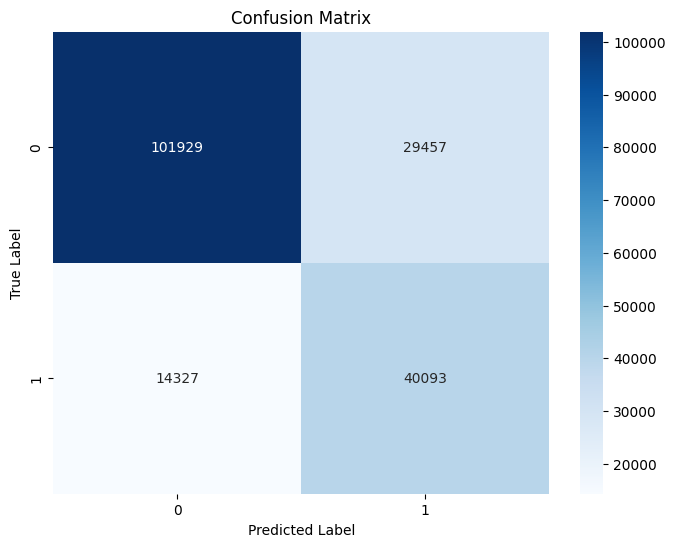

In [ ]:
#visualisation

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
#↓ Model 3 : KNN


--- Preprocessor dry run to determine feature dimension ---
Dry run preprocessor fit_transform took: 0.55 seconds
Estimated total features after ColumnTransformer (with Target Encoding): 22

Starting RandomizedSearchCV (KNN with Target Encoding and Feature Selection)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
RandomizedSearchCV fit took: 2514.15 seconds

--- RandomizedSearchCV Results ---
Best Parameters: {'feature_selection__k': 22, 'knn__metric': 'euclidean', 'knn__n_neighbors': 125, 'knn__weights': 'distance', 'preprocessor__high_card_destination__target_encode_destination_encoded__smoothing': 1.0, 'preprocessor__high_card_origin__target_encode_origin_encoded__smoothing': 1.0, 'preprocessor__high_card_station__target_encode_station_pair_encoded__smoothing': 1.0}
Best Cross-Validation Score (f1_macro): 0.8032511441242572


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


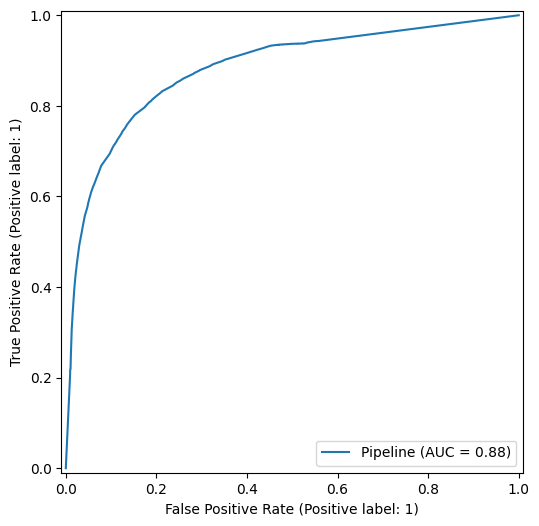

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



--- model accuracy ---
              precision    recall  f1-score   support

           0       0.87      0.92      0.90    133792
           1       0.78      0.67      0.72     55499

    accuracy                           0.85    189291
   macro avg       0.82      0.79      0.81    189291
weighted avg       0.84      0.85      0.84    189291

Accuracy on Test Set: 0.8472


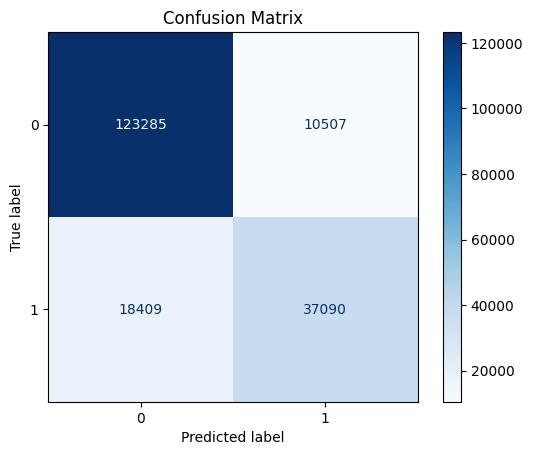

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Successfully extracted and applied 'preprocessor' from the Pipeline.
Successfully extracted and applied 'feature_selection' from the Pipeline.


/usr/local/lib/python3.11/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,RocCurveDisplay
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin
import joblib
from sklearn.inspection import permutation_importance
from scipy.stats import randint, uniform
import time
from google.colab import files
import umap.umap_ as umap


# --- Customized TargetEncoder ---
class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, column, default_value=None, smoothing=1.0):
        self.column = column
        self.mean_target_map = None
        self.default_value = default_value
        self.smoothing = smoothing
        self.global_mean = None

    def fit(self, X, y):
        if isinstance(X, pd.DataFrame):
            X_series = X[self.column]
        elif isinstance(X, np.ndarray) and X.ndim == 1:
            X_series = pd.Series(X)
        else:
            X_series = pd.Series(X[:,0])

        self.global_mean = y.mean()
        temp_df = pd.DataFrame({self.column: X_series, 'target': y})
        agg_df = temp_df.groupby(self.column)['target'].agg(['mean', 'count'])

        self.mean_target_map = (agg_df['count'] * agg_df['mean'] + self.smoothing * self.global_mean) / \
                               (agg_df['count'] + self.smoothing)

        if self.default_value is None:
            self.default_value = self.global_mean
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X_series = X[self.column]
        elif isinstance(X, np.ndarray) and X.ndim == 1:
            X_series = pd.Series(X)
        else:
            X_series = pd.Series(X[:,0])

        encoded_data = X_series.map(self.mean_target_map).fillna(self.default_value)

        return encoded_data.values.reshape(-1, 1)


# --- combine infrequent data ---
class InfrequentCategoryGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, column, threshold=0.05, replacement_value=-1):
        self.column = column
        self.threshold = threshold
        self.replacement_value = replacement_value
        self.rare_categories = None

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X_series = X[self.column]
        elif isinstance(X, np.ndarray) and X.ndim == 1:
            X_series = pd.Series(X)
        else:
            X_series = pd.Series(X[:,0])

        value_counts = X_series.value_counts(normalize=True)
        self.rare_categories = value_counts[value_counts < self.threshold].index.tolist()
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X_series = X[self.column]
        elif isinstance(X, np.ndarray) and X.ndim == 1:
            X_series = pd.Series(X)
        else:
            X_series = pd.Series(X[:,0])

        transformed_series = X_series.replace(self.rare_categories, self.replacement_value)

        return transformed_series.values.reshape(-1, 1)


# --- load data ---
try:
    all_columns = ['hour','hour_is_weekend','hour_is_holiday','station_pair_encoded','origin_encoded','destination_encoded','day_of_week','is_holiday','hour_bin','is_weekend']

    numeric_features = [
        'hour',
        'hour_is_weekend',
        'hour_is_holiday',
    ]

    high_cardinality_categorical_features = [
        'station_pair_encoded',
        'origin_encoded',
        'destination_encoded'
    ]

    low_cardinality_categorical_features = [
        'day_of_week',
        'is_holiday',
        'hour_bin',
        'is_weekend',
    ]

    X = df[all_columns]
    y = df['peak_label']

    # --- data splitting ---
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


    # --- ColumnTransformer ---
    target_encoder_pipeline = lambda col: Pipeline([
        (f'target_encode_{col}', TargetEncoder(column=col, smoothing=1.0))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('high_card_station', target_encoder_pipeline('station_pair_encoded'), ['station_pair_encoded']),
            ('high_card_destination', target_encoder_pipeline('destination_encoded'), ['destination_encoded']),
            ('high_card_origin', target_encoder_pipeline('origin_encoded'), ['origin_encoded']),
            ('low_card_cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), low_cardinality_categorical_features)
        ],
        remainder='drop'
    )

    # --- Pipeline ---
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(score_func=f_classif)),
        ('knn', KNeighborsClassifier())
    ])

    print("\n--- Preprocessor dry run to determine feature dimension ---")
    start_time_dry_run = time.time()
    temp_transformed_X_train = preprocessor.fit_transform(X_train, y_train)
    end_time_dry_run = time.time()
    print(f"Dry run preprocessor fit_transform took: {end_time_dry_run - start_time_dry_run:.2f} seconds")
    total_features_after_ct = temp_transformed_X_train.shape[1]
    print(f"Estimated total features after ColumnTransformer (with Target Encoding): {total_features_after_ct}")

    """
    Best Parameters: {'feature_selection__k': 22, 'knn__metric': 'euclidean', 'knn__n_neighbors': 125, 'knn__weights': 'distance', 'preprocessor__high_card_destination__target_encode_destination_encoded__smoothing': 1.0, 'preprocessor__high_card_origin__target_encode_origin_encoded__smoothing': 1.0, 'preprocessor__high_card_station__target_encode_station_pair_encoded__smoothing': 1.0}
    Best Cross-Validation Score (f1_macro): 0.8040327970577812
    """

    param_distributions = {
        'knn__n_neighbors': randint(125,126), # to make it faster, from randint(50,150) -> 125,126
        'knn__weights': ['distance'], # 'knn__weights': ['uniform', 'distance'],
        'knn__metric': ['euclidean'], #'knn__metric': ['euclidean', 'manhattan'],
        'feature_selection__k': randint(22,23),#'feature_selection__k': randint(max(1, int(total_features_after_ct * 0.1)), total_features_after_ct + 1),
        'preprocessor__high_card_station__target_encode_station_pair_encoded__smoothing': [1.0],
        'preprocessor__high_card_destination__target_encode_destination_encoded__smoothing': [1.0],
        'preprocessor__high_card_origin__target_encode_origin_encoded__smoothing': [1.0],
    }

    # --- use RandomSearchCV to find the k value

    n_iter_search = 1 # to make it faster, from 10 -> 1
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_distributions,
        n_iter=n_iter_search,
        cv=cv_strategy,
        scoring='f1_macro',
        n_jobs=-1,
        verbose=2,
        random_state=42
    )

    print("\nStarting RandomizedSearchCV (KNN with Target Encoding and Feature Selection)...")
    start_time_rs = time.time()
    random_search.fit(X_train, y_train)
    end_time_rs = time.time()
    print(f"RandomizedSearchCV fit took: {end_time_rs - start_time_rs:.2f} seconds")

    # knn model
    best_knn_model = random_search.best_estimator_
    best_params = random_search.best_params_

    # new_data_df = pd.DataFrame([new_data_point], columns=all_columns)
    # predicted_label = best_knn_model.predict(new_data_df)
    # print(f"\nresult：{predicted_label[0]}")

    print("\n--- RandomizedSearchCV Results ---")
    print("Best Parameters:", best_params)
    print("Best Cross-Validation Score (f1_macro):", random_search.best_score_)

    # roc curve display
    plt.figure(figsize=(8,6))
    RocCurveDisplay.from_estimator(best_knn_model, X_test, y_test, ax=plt.gca())
    plt.show()

    y_pred = best_knn_model.predict(X_test)

    print("\n--- model accuracy ---")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy on Test Set: {accuracy_score(y_test, y_pred):.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_knn_model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # ---permutation importance---
    #result = permutation_importance(best_knn_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    #sorted_idx = result.importances_mean.argsort()
    #fig, ax = plt.subplots(figsize=(10, 6))
    #ax.boxplot(result.importances[sorted_idx].T, vert=False, tick_labels=X_test.columns[sorted_idx])
    #ax.set_title("Permutation Importance (Test Set)")
    #ax.set_xlabel("Decrease in accuracy")
    #plt.tight_layout()
    #plt.show()

    fitted_preprocessor = best_knn_model.named_steps['preprocessor']
    X_test_preprocessed = fitted_preprocessor.transform(X_test)
    print("Successfully extracted and applied 'preprocessor' from the Pipeline.")

    fitted_feature_selector = best_knn_model.named_steps['feature_selection']
    X_test_selected_features = fitted_feature_selector.transform(X_test_preprocessed)
    print("Successfully extracted and applied 'feature_selection' from the Pipeline.")

    umap_reducer = umap.UMAP(n_components=2,
                         n_neighbors=15,
                         min_dist=0.1,
                         metric='euclidean',
                         random_state=42)

    X_test_reduced_umap = umap_reducer.fit_transform(X_test_selected_features)
    print("Applied UMAP on the preprocessed and feature-selected test data for visualization.")

    classification_status = []
    for true_label, pred_label in zip(y_test, y_pred):
        if true_label == 0 and pred_label == 0:
            classification_status.append('True Negative (Actual 0, Predicted 0)')
        elif true_label == 1 and pred_label == 1:
            classification_status.append('True Positive (Actual 1, Predicted 1)')
        elif true_label == 0 and pred_label == 1:
            classification_status.append('False Positive (Actual 0, Predicted 1)')
        elif true_label == 1 and pred_label == 0:
            classification_status.append('False Negative (Actual 1, Predicted 0)')

    classification_status_series = pd.Series(classification_status)

    plt.figure(figsize=(12, 10))
    color_map = {
        'True Negative (Actual 0, Predicted 0)': 'lightgreen',
        'True Positive (Actual 1, Predicted 1)': 'lightblue',
        'False Positive (Actual 0, Predicted 1)': 'red',
        'False Negative (Actual 1, Predicted 0)': 'orange'
    }

    sns.scatterplot(
        x=X_test_reduced_umap[:, 0],
        y=X_test_reduced_umap[:, 1],
        hue=classification_status_series,
        palette=color_map,
        s=15,
        alpha=0.6,
        edgecolor='w',
        linewidth=0.5
    )

    plt.title('Umap Visualization of KNN Classification Results', fontsize=16)
    plt.xlabel('Umap Component 1', fontsize=12)
    plt.ylabel('Umap Component 2', fontsize=12)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.show()

except FileNotFoundError as fnfe:
    print(f"File not found: {fnfe}")
    exit()
except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()
    exit()

    #collect result
results.append({
    'Model': 'SVC',
    'Accuracy': accuracy_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
})

In [ ]:
#↓ Model 4 : Linear SVC

In [ ]:
# 🔍 Add more informative features
df['hour_is_weekend'] = df['hour'] * df['is_weekend']
df['hour_is_holiday'] = df['hour'] * df['is_holiday']
df['is_rush_hour'] = df['hour'].isin([7, 8, 9, 17, 18, 19]).astype(int)
df['is_workday_morning'] = ((df['day_of_week'] < 5) & (df['hour'] < 10)).astype(int)
df['day_type'] = df['is_holiday'] + df['is_weekend']  # 0=normal, 1=holiday/weekend, 2=bothbothbothboth
df['combined_hour_day'] = df['hour'] * df['day_of_week']

features = [
    'hour', 'day_of_week', 'is_holiday', 'is_weekend', 'station_pair_encoded',
    'hour_is_weekend', 'hour_is_holiday', 'is_rush_hour',
    'is_workday_morning', 'day_type', 'combined_hour_day'
]

x = df[features]
y = df['peak_label']

In [ ]:
# Features to one-hot encode
categorical_features = ['station_pair_encoded', 'day_of_week', 'day_type']
# Features to scale
numeric_features = ['hour', 'hour_is_weekend', 'hour_is_holiday', 'combined_hour_day']

# All other features to pass through as is
passthrough_features = ['is_holiday', 'is_weekend', 'is_rush_hour', 'is_workday_morning']

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features),
        ('pass', 'passthrough', passthrough_features)
    ])

svc_pipeline = make_pipeline(preprocessor, LinearSVC(random_state=42, max_iter=10000, class_weight='balanced'))

# Train/test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Fit model
svc_pipeline.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['station_pair_encoded',
                                                   'day_of_week', 'day_type']),
                                                 ('num', StandardScaler(),
                                                  ['hour', 'hour_is_weekend',
                                                   'hour_is_holiday',
                                                   'combined_hour_day']),
                                                 ('pass', 'passthrough',
                                                  ['is_holiday', 'is_weekend',
                                                   'is_rush_hour',
                                                   'is_workday_morning'])])),
                ('linearsvc',
                 LinearSVC(class_weight='balanced', max_iter=10000,
                           random_state=42))])

In [ ]:
# Predict and evaluate
y_pred = svc_pipeline.predict(x_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Confusion Matrix:
 [[145342  54348]
 [ 16385  66108]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.73      0.80    199690
           1       0.55      0.80      0.65     82493

    accuracy                           0.75    282183
   macro avg       0.72      0.76      0.73    282183
weighted avg       0.80      0.75      0.76    282183

Accuracy: 0.7493364235265767
F1 Score: 0.6514740156393971


In [ ]:
# 5-fold Cross-validation
cv_scores = cross_val_score(svc_pipeline, x, y, cv=5, scoring='f1')
print("✅ CV F1 Scores:", cv_scores)
print("✅ Mean CV F1 Score:", round(cv_scores.mean(), 4))

In [ ]:
# Check class distribution
print("✅ Class distribution:\n", df['peak_label'].value_counts())

sns.countplot(data=df, x='peak_label')
plt.title('Peak vs Off-Peak Distribution')
plt.xlabel('Peak Label (0 = Off-Peak, 1 = Peak)')
plt.ylabel('Count')
plt.show()

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Select only numerical features for correlation
corr_features = ['hour', 'day_of_week', 'is_holiday', 'peak_label']
corr_matrix = df[corr_features].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
# Use only 2 features for visualization: 'hour' and 'day_of_week'
features_vis = ['hour', 'day_of_week']
x_vis = df[features_vis]
y_vis = df['peak_label']

# Sample a smaller dataset to speed up plotting
x_sample = x_vis.sample(n=5000, random_state=42)
y_sample = y_vis.loc[x_sample.index]

# Train model on sample
model_vis = LinearSVC(max_iter=10000, random_state=42)
model_vis.fit(x_sample, y_sample)

# Create a meshgrid for plotting decision boundaries
h = 0.2
x_min, x_max = x_sample['hour'].min() - 1, x_sample['hour'].max() + 1
y_min, y_max = x_sample['day_of_week'].min() - 1, x_sample['day_of_week'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predict on grid points
Z = model_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)
plt.scatter(x_sample['hour'], x_sample['day_of_week'], c=y_sample, cmap=plt.cm.coolwarm, edgecolors='k', s=20)
plt.xlabel('Hour')
plt.ylabel('Day of Week')
plt.title('Linear SVM Decision Boundary (Hour vs Day of Week)')
plt.colorbar(label='Peak Label')
plt.show()

In [ ]:
#collect result
results.append({
    'Model': 'SVC',
    'Accuracy': accuracy_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
})

In [ ]:
#↓ Model 5 : Random Forest

In [ ]:
#  Define features and target for Random Forest
features_tree = ['hour', 'day_of_week', 'is_holiday', 'hour_bin', 'is_weekend', 'hour_is_weekend', 'hour_is_holiday', 'station_pair_encoded', 'origin_encoded', 'destination_encoded']
X = df[features_tree]
y = df['peak_label']


In [ ]:
from sklearn.model_selection import train_test_split

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100],
    'max_depth': [10, None],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}


In [ ]:
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_scaled, y_train)

best_rf = grid.best_estimator_
print("✅ Best Random Forest Parameters:", grid.best_params_)

In [ ]:
# Evaluate Random Forest
y_pred = best_rf.predict(X_test_scaled)
print("🔍 Accuracy:", accuracy_score(y_test, y_pred))
print("📋 Classification Report:\n", classification_report(y_test, y_pred))
print("🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [ ]:
#collect result
results.append({
    'Model': 'Random Forest',
    'Accuracy': accuracy_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
})

In [ ]:
# Plot confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Peak', 'Peak'], yticklabels=['Not Peak', 'Peak'])
plt.title("🔍 Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Train Decision Tree Classifier (no need for scaling but we use scaled for fair comparison)
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_dt = dt_model.predict(X_test_scaled)

print("\n🌲 Decision Tree Classifier Results")
print("🔍 Accuracy:", accuracy_score(y_test, y_pred_dt))
print("📋 Classification Report:\n", classification_report(y_test, y_pred_dt))
print("🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

# Compare Accuracies
print("\n📊 Model Comparison:")
print("✅ Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("🌲 Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))


In [ ]:
#↓ Conclusion

In [ ]:
results_df = pd.DataFrame(results)
print(results_df)

In [ ]:
# Plot Accuracy comparison
results_df.plot(x='Model', y='Accuracy', kind='bar', legend=False)
plt.ylabel('Accuracy')
plt.title('Model Comparison - Accuracy')
plt.ylim(0,1)  # Optional: force y-axis 0 to 1
plt.show()

# Plot F1 Score comparison
results_df.plot(x='Model', y='F1 Score', kind='bar', color='orange', legend=False)
plt.ylabel('F1 Score')
plt.title('Model Comparison - F1 Score')
plt.ylim(0,1)
plt.show()

# Autogluon

---



In [ ]:
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split
import pandas as pd
from google.colab import files

uploaded = files.upload()
df = pd.read_csv('v3_cleaned_ktmb_data.csv')

features_tree = ['hour', 'day_of_week', 'is_holiday', 'hour_bin', 'is_weekend', 'hour_is_weekend', 'hour_is_holiday', 'station_pair_encoded', 'origin_encoded', 'destination_encoded']
X = df[features_tree]
y = df['peak_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

TARGET_COLUMN = 'peak_label'
train_data_ag = X_train.copy()
train_data_ag[TARGET_COLUMN] = y_train

predictor = TabularPredictor(
    label=TARGET_COLUMN,
    eval_metric='f1_macro',
    path="c:/Users/vyyh/Desktop/AutogluonModels_ForComparison"
).fit(
    train_data_ag,
    time_limit=3600,
    presets='medium_quality',
)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve
import joblib
from autogluon.tabular import TabularPredictor
import seaborn as sns
import numpy as np
from category_encoders import TargetEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib
matplotlib.use('QtAgg')
import matplotlib.pyplot as plt
from google.colab import files

uploaded = files.upload()
data_frame = pd.read_csv('v3_cleaned_ktmb_data.csv')

features_columns = ['hour', 'day_of_week', 'is_holiday', 'hour_bin', 'is_weekend', 'hour_is_weekend', 'hour_is_holiday', 'station_pair_encoded', 'origin_encoded', 'destination_encoded']
TARGET_COLUMN = 'peak_label'

X = data_frame[features_columns]
y = data_frame[TARGET_COLUMN]

X_train_dummy, X_test, y_train_dummy, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df_output = X.copy()

        df_output['is_rush_hour'] = df_output['hour'].isin([7, 8, 9, 17, 18, 19]).astype(int)
        df_output['is_workday_morning'] = ((df_output['day_of_week'] < 5) & (df_output['hour'] < 10)).astype(int)
        df_output['day_type'] = df_output['is_holiday'] + df_output['is_weekend']
        df_output['combined_hour_day'] = df_output['hour'] * df_output['day_of_week']

        return df_output


class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, column, default_value=None):
        self.column = column
        self.mean_target_map = None
        self.default_value = default_value
    def fit(self, X, y):
        if not isinstance(X, pd.DataFrame) or X.shape[1] != 1 or X.columns[0] != self.column:
            X_temp = pd.DataFrame(X, columns=[self.column])
        else:
            X_temp = X.copy()
        temp_df = X_temp.copy()
        temp_df['target'] = y
        self.mean_target_map = temp_df.groupby(self.column)['target'].mean()
        if self.default_value is None:
            self.default_value = y.mean()
        return self
    def transform(self, X):
        if not isinstance(X, pd.DataFrame) or X.shape[1] != 1 or X.columns[0] != self.column:
            X_transformed_df = pd.DataFrame(X, columns=[self.column])
        else:
            X_transformed_df = X.copy()
        encoded_col_name = f"{self.column}_target_encoded"
        X_transformed_df[encoded_col_name] = X_transformed_df[self.column].map(self.mean_target_map)
        X_transformed_df[encoded_col_name].fillna(self.default_value, inplace=True)
        return X_transformed_df[[encoded_col_name]]

class InfrequentCategoryGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, column, threshold=0.05, replacement_value=-1):
        self.column = column
        self.threshold = threshold
        self.replacement_value = replacement_value
        self.rare_categories = None
    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame) or X.shape[1] != 1 or X.columns[0] != self.column:
            X_temp = pd.DataFrame(X, columns=[self.column])
        else:
            X_temp = X.copy()
        value_counts = X_temp[self.column].value_counts(normalize=True)
        self.rare_categories = value_counts[value_counts < self.threshold].index.tolist()
        return self
    def transform(self, X):
        if not isinstance(X, pd.DataFrame) or X.shape[1] != 1 or X.columns[0] != self.column:
            X_transformed_df = pd.DataFrame(X, columns=[self.column])
        else:
            X_transformed_df = X.copy()
        X_transformed_df[self.column] = X_transformed_df[self.column].replace(self.rare_categories, self.replacement_value)
        return X_transformed_df[[self.column]]


#load autogluon model
#\\wsl.localhost\Ubuntu-24.04\home\vyyh\my_autogluon_project\AutogluonModels_ForComparison
ag_model_path = './AutogluonModels_ForComparison'
predictor_ag = TabularPredictor.load(ag_model_path)

custom_models = {}
model_names = ["knn", "logistic_regression", "decision_tree", "random_forest", "linear_svc"]

# load knn, random forest, svm, logistic regression, decision tree models
print("\n--- loading the five models---")
for model_name in model_names:
    model_filename = f'best_{model_name}_model.pkl'
    try:
        model_instance = joblib.load(model_filename)
        custom_models[model_name] = model_instance
        print(f"model '{model_name}'was loaded from '{model_filename}'")
    except FileNotFoundError:
        print(f"warning : model '{model_name}' cannot be found")
    except Exception as e:
        print(f"Error with model loading'{model_name}': {e}")

all_models = {**custom_models}
all_models["AutoGluon"] = predictor_ag

# test the model using the x_test
model_predictions = {}
model_probabilities = {}

for model_name, model_instance in all_models.items():
    try:
        if model_name == "AutoGluon":
            y_pred = model_instance.predict(X_test)
            y_proba = model_instance.predict_proba(X_test)[1]
        else:
            y_pred = model_instance.predict(X_test)
            if hasattr(model_instance, 'predict_proba') and callable(model_instance.predict_proba):
                y_proba = model_instance.predict_proba(X_test)[:, 1]
            else:
                print(f"Warning ! model '{model_name}' did not support pridict_proba")

        model_predictions[model_name] = y_pred
        model_probabilities[model_name] = y_proba
    except Exception as e:
        print(f"Model '{model_name}' unable to do prediction {e}")
        model_predictions[model_name] = None
        model_probabilities[model_name] = None

print("done")

# evaluate the model
def get_model_metrics(model_name, y_true, y_pred, y_proba=None):
    if y_pred is None:
        return {'Accuracy': np.nan, 'F1-macro': np.nan, 'Class1_F1': np.nan, 'AUC-ROC': np.nan, 'Report': 'Prediction Failed'}

    report_str = classification_report(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_minority = f1_score(y_true, y_pred, pos_label=1, zero_division=0)

    auc_roc = np.nan
    if y_proba is not None:
        try:
            auc_roc = roc_auc_score(y_true, y_proba)
        except ValueError as e:
            print(f"Warning : model '{model_name}' failed to calculate AUC_ROC: {e}")
            auc_roc = np.nan

    print(f"\n--- {model_name} evaluation report---")
    print(report_str)
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-macro: {f1_macro:.4f}")
    print(f"  Class 1 (Minority) F1-score: {f1_minority:.4f}")
    if not np.isnan(auc_roc):
        print(f"  AUC-ROC: {auc_roc:.4f}")

    return {'Accuracy': accuracy, 'F1-macro': f1_macro, 'Class1_F1': f1_minority, 'AUC-ROC': auc_roc, 'Report': report_str}

final_comparison_results = {}
for model_name in all_models.keys():
    y_pred = model_predictions.get(model_name)
    y_proba = model_probabilities.get(model_name)
    final_comparison_results[model_name] = get_model_metrics(model_name, y_test, y_pred, y_proba)

print("\n---report of all models---")
results_df = pd.DataFrame(final_comparison_results).T
display_results_df = results_df.drop(columns=['Report'], errors='ignore')
print(display_results_df.sort_values(by='F1-macro', ascending=False))

# plot roc
plt.figure(figsize=(10, 8))
colors = sns.color_palette("husl", len(all_models))
color_idx = 0

for model_name, y_proba in model_probabilities.items():
    if y_proba is not None and not pd.Series(y_proba).isnull().all():
        try:
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = roc_auc_score(y_test, y_proba)
            plt.plot(fpr, tpr, color=colors[color_idx], lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
            color_idx += 1
        except Exception as e:
            print(f"cannot plot ROC of model '{model_name}', error : {e}")
    else:
        print(f"model '{model_name}' does not support predict_proba")

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right", bbox_to_anchor=(1.05, 0.0), borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
plt.show()